# MMSegmentation Framework

## Basic immports

Things we have to take into account:
- The dataset is created in . If not, uncomment the code at the end of the next cell.

1.12.0+cu113 True
1.2.2
NVIDIA GeForce RTX 4070 Laptop GPU
47
47


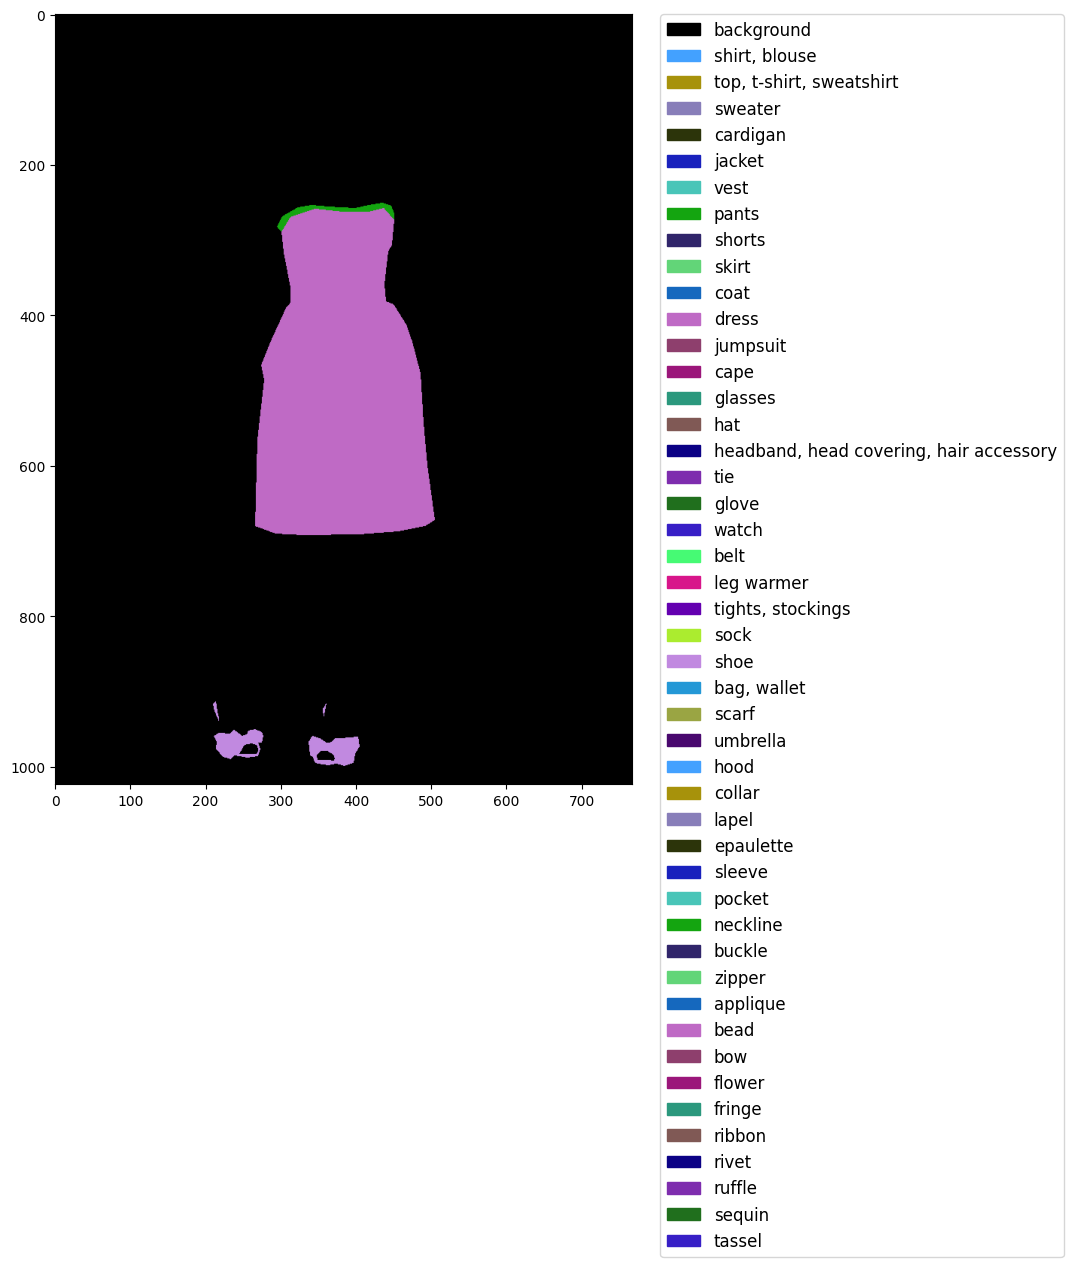

KeyError: 'FashionBG is already registered in dataset at __main__'

In [42]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

import numpy as np

# check cuda
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

import os
if "mmsegmentation" not in os.getcwd():
    os.chdir("mmsegmentation")

# define dataset root and directory for images and annotations
from src import config
data_root = '../' + config.dataDir
img_dir = os.path.join(data_root, 'images')
ann_dir = os.path.join(data_root, 'annotations')
# define class and palette for better visualization
classes = list(config.d_cats_bg.values())
palette = config.COLORS

print(len(palette))
print(len(classes))

assert len(palette) == len(classes)

# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15, 10))
# im = plt.imshow(np.array(img.convert('RGB')))

mask = cv2.imread('fashion/annotations/train2020/0a0f64ffdb6aa45b0f445b217b05a6c6_seg.png', cv2.IMREAD_GRAYSCALE)

# For all the values in the mask, we will create a new mask with the same shape but with the color of the category
mask_color = np.zeros((mask.shape[0], mask.shape[1], 3))
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask_color[i, j] = palette[mask[i, j]]

mask_color = mask_color.astype(np.uint8)
plt.imshow(mask_color)
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

# from mmseg.registry import DATASETS
# from mmseg.datasets import BaseSegDataset


# @DATASETS.register_module()
# class FashionBG(BaseSegDataset):
#   METAINFO = dict(classes = classes, palette = palette)
#   def __init__(self, **kwargs):
#     super().__init__(img_suffix='.jpg', seg_map_suffix='_seg.png', **kwargs)

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [30]:
# Download config and checkpoint files
# !mim download mmsegmentation --config pspnet_r18-d8_4xb4-80k_isaid-896x896 --dest .

In [31]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r18-d8_4xb4-80k_isaid-896x896.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    896,
    896,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        896,
        896,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/iSAID'
dataset_type = 'iSAIDDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=8000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_fr

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [32]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (128, 128)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 47
cfg.model.auxiliary_head.num_classes = 47

# Modify dataset type and path
cfg.dataset_type = 'FashionBG'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 4

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path='images/train2020', seg_map_path='annotations/train2020')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
# cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path='images/val2020', seg_map_path='annotations/val2020')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
# cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_r18-d8_4x4_896x896_80k_isaid_20220110_180526-e84c0b6a.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    128,
    128,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        896,
        896,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '../datasets/fashion/'
dataset_type = 'FashionBG'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
l

### Train and Evaluation

In [33]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/05 16:24:15 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU
    CUDA_HOME: /usr/lib/cuda
    NVCC: Not Available
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 1.12.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;

/bin/sh: 1: /usr/lib/cuda/bin/nvcc: not found
/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.75 GiB total capacity; 65.86 MiB already allocated; 2.56 MiB free; 68.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [34]:
# start training
runner.train()

04/05 16:24:15 - mmengine - WARNING - init_weights of EncoderDecoder has been called more than once.
04/05 16:24:15 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
04/05 16:24:15 - mmengine - INFO - Checkpoints will be saved to /home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/work_dirs/tutorial.


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.75 GiB total capacity; 67.86 MiB already allocated; 576.00 KiB free; 70.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Inference with trained model

/home/alberto/Documentos/GitHub/OR_FashionParsing/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_200.pth


/home/alberto/anaconda3/envs/openmmlab2/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


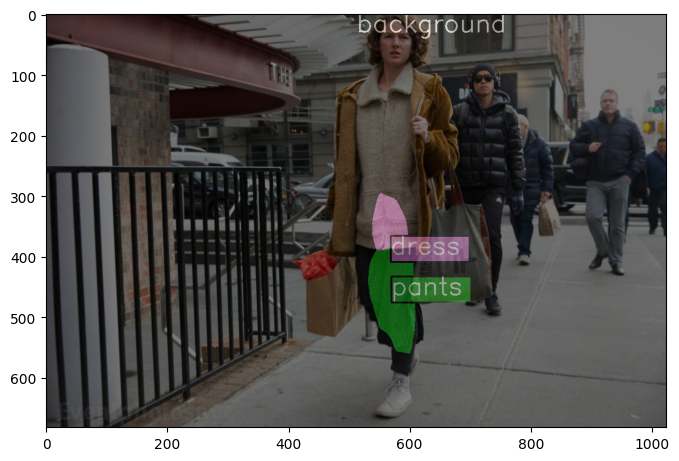

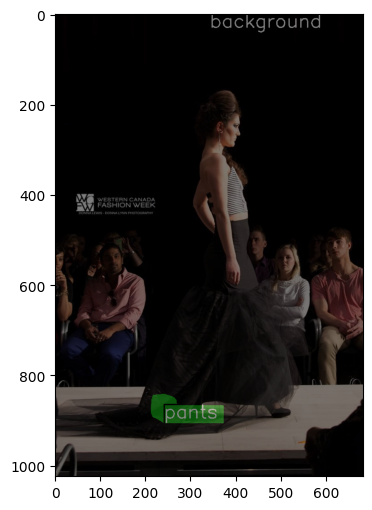

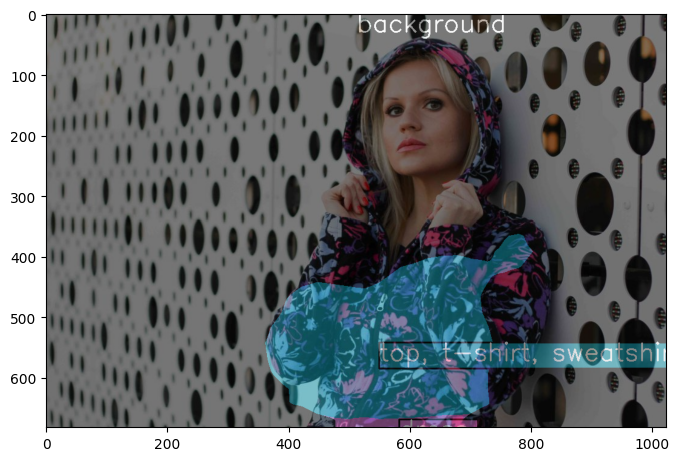

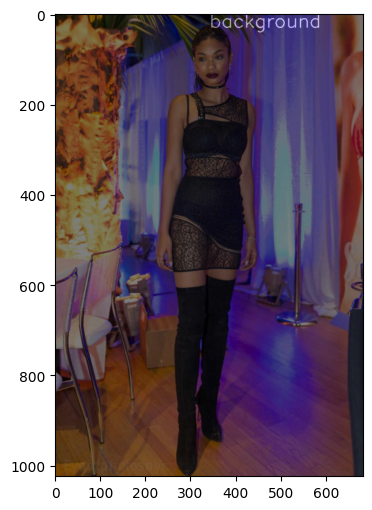

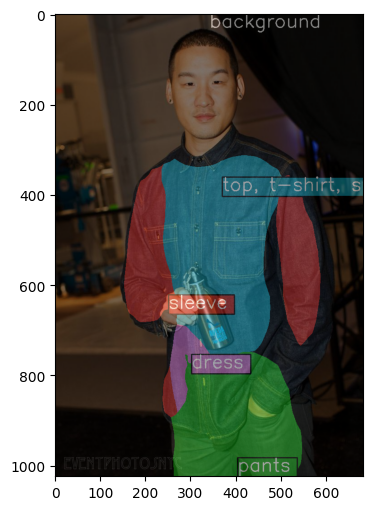

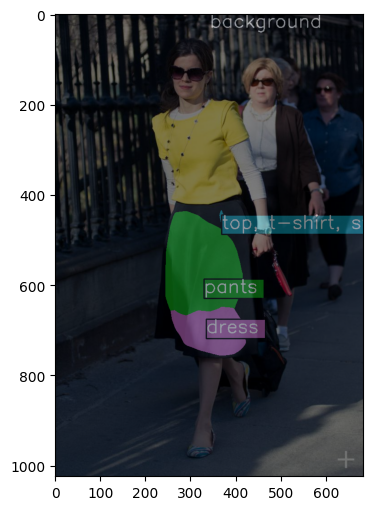

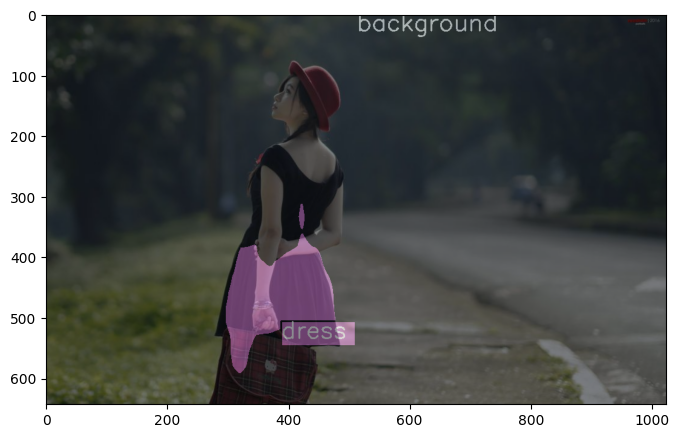

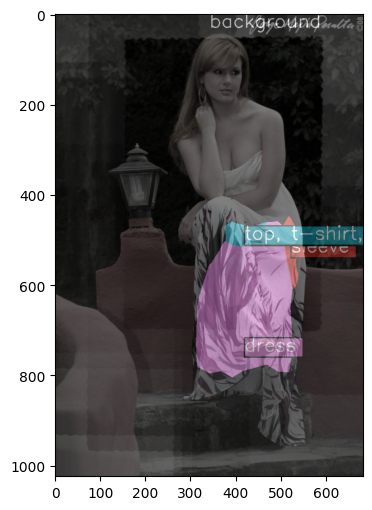

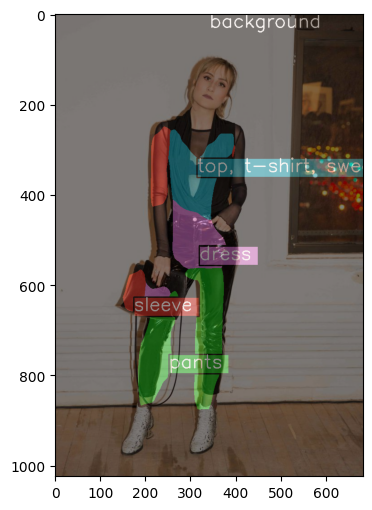

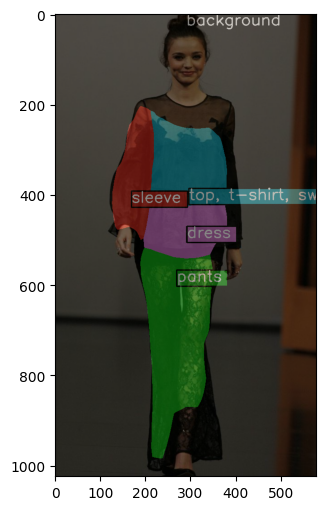

In [24]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

for i in range(10):
    ls_test = os.listdir('../datasets/fashion/images/test2020')
    img = mmcv.imread(f'../datasets/fashion/images/test2020/{ls_test[i]}')
    result = inference_model(model, img)
    plt.figure(figsize=(8, 6))
    vis_result = show_result_pyplot(model, img, result)
    plt.imshow(mmcv.bgr2rgb(vis_result))
    plt.show()
